In [2]:
%pip install pillow==10.4.0
%pip install captum

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch.backends import cudnn


cuda_available = torch.cuda.is_available()


cudnn.benchmark = False
cudnn.deterministic = True

print(f"CUDA Available: {cuda_available}")

if cuda_available:
   
    num_devices = torch.cuda.device_count()
    print(f"Number of CUDA Devices: {num_devices}")
    

    for device_id in range(num_devices):
        device_name = torch.cuda.get_device_name(device_id)
        total_memory = torch.cuda.get_device_properties(device_id).total_memory
        memory_allocated = torch.cuda.memory_allocated(device_id)
        memory_cached = torch.cuda.memory_reserved(device_id)

        print(f"Device {device_id}: {device_name}")
        print(f"  Total Memory: {total_memory / (1024**3):.2f} GB")
        print(f"  Memory Allocated: {memory_allocated / (1024**2):.2f} MB")
        print(f"  Memory Cached: {memory_cached / (1024**2):.2f} MB")

CUDA Available: True
Number of CUDA Devices: 2
Device 0: GeForce RTX 2060
  Total Memory: 5.79 GB
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
Device 1: GeForce RTX 2060
  Total Memory: 5.80 GB
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB


/home/aut140302_ria/workspace/arian/Consistency-Adversarial/cons-venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda:1")
# torch.cuda.empty_cache()
device

device(type='cuda', index=1)

In [5]:
#Load pickles
import pickle

true_labels = []
adv_imgs = []
original_imgs = []

tl_path = '/data/true_labels_1000_20itr_samples.pkl'
adv_path= '/data/adv_images_1000_20itr_samples.pkl'
org_path = '/data/original_images_1000_20itr_samples.pkl'

with open(tl_path,'rb') as file:
    true_labels = pickle.load(file)
    
with open(adv_path,'rb') as file:
    adv_imgs = pickle.load(file)

with open(org_path,'rb') as file:
    original_imgs = pickle.load(file)    

In [6]:
all_adv_images = []
for b in adv_imgs:
  for i in b:
    all_adv_images.append(i)

all_adv_images = torch.stack(all_adv_images)
all_adv_images = all_adv_images.to(device)
print(all_adv_images.shape)

torch.Size([1000, 3, 224, 224])


In [7]:
all_org_images = []
for b in original_imgs:
  for i in b:
    all_org_images.append(i)



all_org_images = torch.stack(all_org_images)
all_org_images = all_org_images.to(device)
print(all_org_images.shape)

torch.Size([1000, 3, 224, 224])


In [8]:
true_labels = true_labels.to(device)
true_labels

tensor([0, 0, 7, 7, 4, 9, 3, 6, 7, 5, 7, 2, 7, 0, 0, 7, 5, 8, 5, 0, 7, 1, 5, 0,
        1, 6, 3, 0, 1, 7, 5, 4, 3, 5, 9, 8, 9, 1, 4, 3, 5, 4, 6, 1, 9, 5, 2, 3,
        3, 6, 0, 1, 1, 5, 6, 1, 1, 3, 5, 0, 8, 3, 3, 8, 4, 4, 9, 0, 8, 2, 1, 9,
        8, 5, 8, 3, 0, 7, 1, 6, 0, 7, 6, 4, 9, 6, 3, 4, 4, 0, 4, 7, 7, 5, 3, 6,
        3, 9, 3, 5, 6, 9, 9, 4, 2, 3, 1, 3, 7, 8, 1, 4, 9, 0, 3, 0, 8, 1, 5, 0,
        6, 9, 3, 8, 3, 5, 1, 8, 5, 0, 9, 1, 5, 8, 8, 3, 3, 2, 0, 3, 6, 4, 3, 3,
        2, 0, 6, 1, 4, 4, 5, 5, 0, 0, 4, 0, 8, 4, 8, 2, 5, 1, 1, 2, 3, 1, 6, 9,
        6, 2, 6, 9, 4, 0, 3, 4, 0, 0, 5, 8, 3, 5, 7, 4, 6, 9, 2, 8, 8, 4, 5, 3,
        6, 3, 7, 1, 6, 0, 8, 7, 6, 4, 8, 8, 3, 2, 1, 3, 8, 6, 3, 4, 9, 3, 1, 1,
        3, 7, 5, 3, 9, 5, 3, 8, 9, 9, 3, 3, 4, 2, 4, 3, 0, 5, 4, 5, 2, 0, 9, 4,
        7, 0, 2, 2, 9, 9, 1, 2, 2, 2, 3, 8, 8, 5, 4, 6, 8, 5, 0, 6, 4, 0, 0, 3,
        9, 3, 3, 9, 0, 8, 5, 5, 9, 2, 5, 3, 7, 8, 3, 1, 1, 2, 7, 2, 8, 3, 5, 1,
        5, 6, 6, 9, 3, 9, 9, 3, 7, 7, 7,

In [9]:
from torchvision.models import resnet18, ResNet18_Weights
from captum.attr import GuidedBackprop,GuidedGradCam
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [10]:
model_res18 = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model_res18.fc.in_features
model_res18.fc = nn.Linear(num_ftrs, 10)


In [11]:
model_path = "/models/res18-ce/model_LastEpoch.pth"

In [12]:
def visualize_all_attributions(img, attributions_list, methods):
    num_plots = len(attributions_list)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    
    img= img.cpu().data.numpy()
    img = img.transpose(1, 2, 0)
    
    for i, (attributions, method) in enumerate(zip(attributions_list, methods)):
        row, col = divmod(i, num_cols)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        attr = attributions.squeeze().cpu().detach().numpy()
        attr = np.transpose(attr, (1, 2, 0))
        attr = np.sum(np.abs(attr), axis=2)
        attr = attr / attr.max()
        ax.imshow(img)
        ax.imshow(attr, cmap='hot', alpha=0.6)
        ax.axis('off')
        ax.set_title(method)
    for i in range(num_plots, num_rows * num_cols):
        row, col = divmod(i, num_cols)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
# Guided BackProp
def compute_guided_backprop_attributions(input_tensor, target, model):
    gbp = GuidedBackprop(model)
    return gbp.attribute(input_tensor, target=target)

# Guided GradCAM
def compute_guided_gradcam_attributions(input_tensor, target, model, layer):
    ggcam = GuidedGradCam(model, layer)
    return ggcam.attribute(input_tensor, target=target)

/home/aut140302_ria/workspace/arian/Consistency-Adversarial/cons-venv/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/aut140302_ria/workspace/arian/Consistency-Adversarial/cons-venv/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


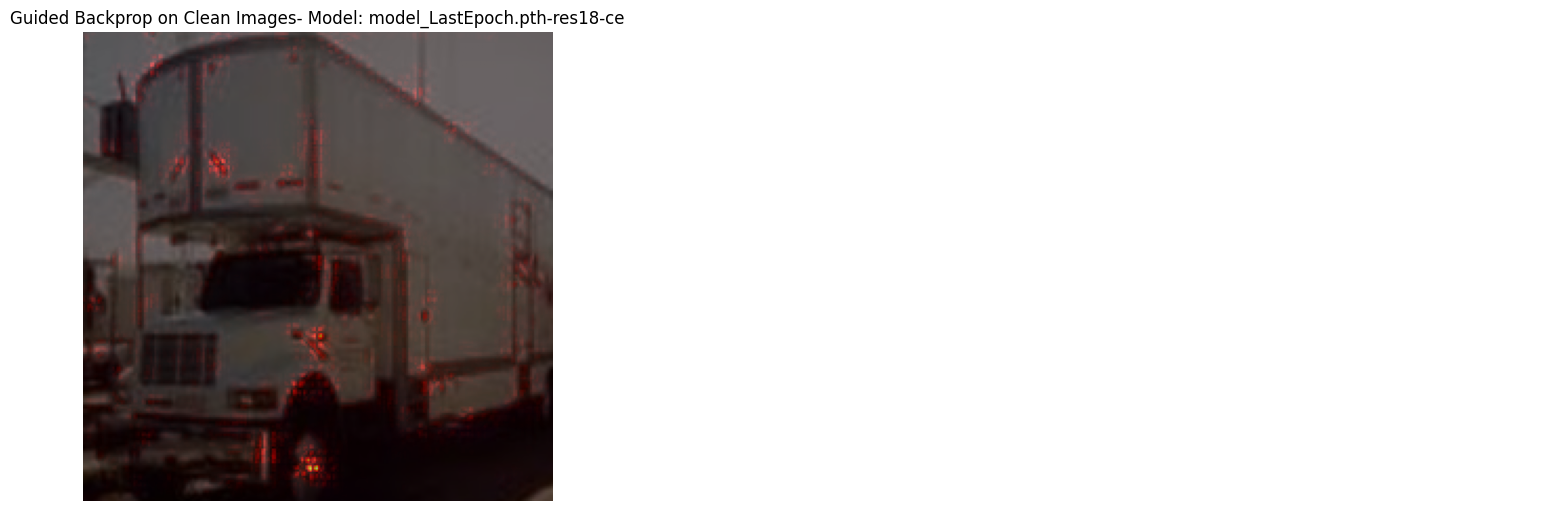

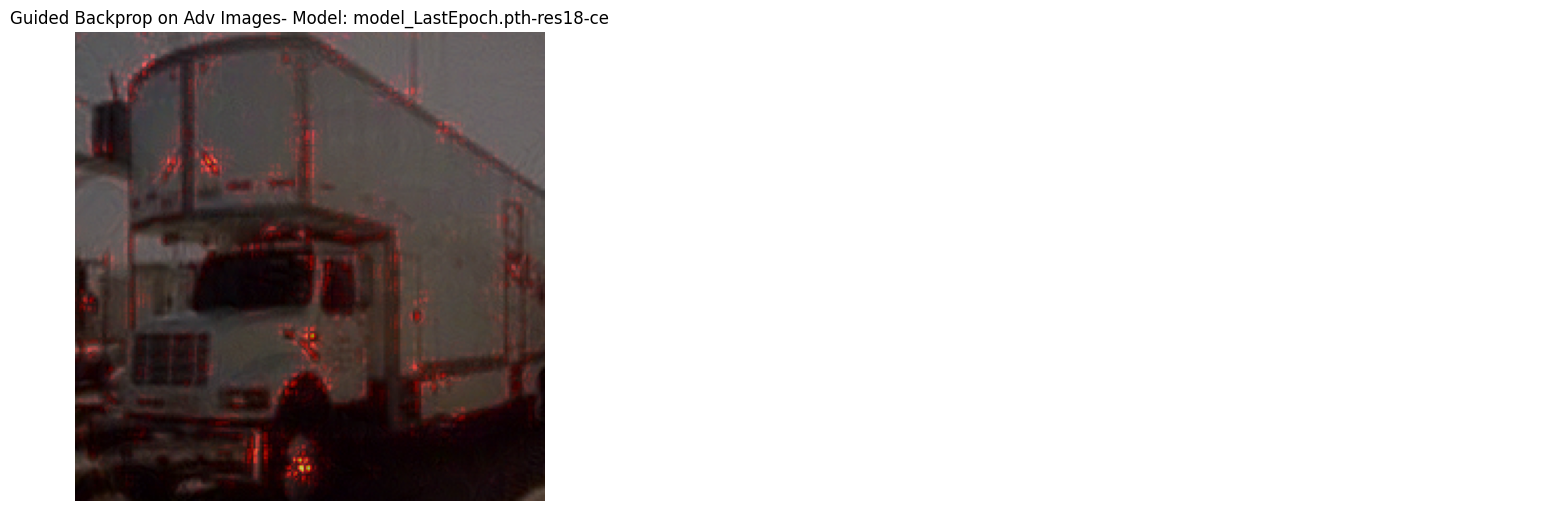

In [14]:
#Guided BackProp On Clean and Adversarial

model_res18.load_state_dict(torch.load(model_path))
model_res18 = model_res18.to(device)
model_res18.eval()
info = p.split('/')
with torch.no_grad():
    outputs = model_res18(all_adv_images[1:2])
    _, adv_predicted = torch.max(outputs, 1)
        
with torch.no_grad():
    outputs = model_res18(all_org_images[1:2])
    _, org_predicted = torch.max(outputs, 1)
    
attributions_org_gbp = compute_guided_backprop_attributions(all_org_images[1:2], org_predicted, model_res18)
visualize_all_attributions(all_org_images[1], [attributions_org_gbp], [f'Guided Backprop on Clean Images- Model: {info[-1]}-{info[-2]}'])
    
attributions_adv_gbp = compute_guided_backprop_attributions(all_adv_images[1:2], adv_predicted, model_res18)
visualize_all_attributions(all_adv_images[1], [attributions_adv_gbp], [f'Guided Backprop on Adv Images- Model: {info[-1]}-{info[-2]}'])
            

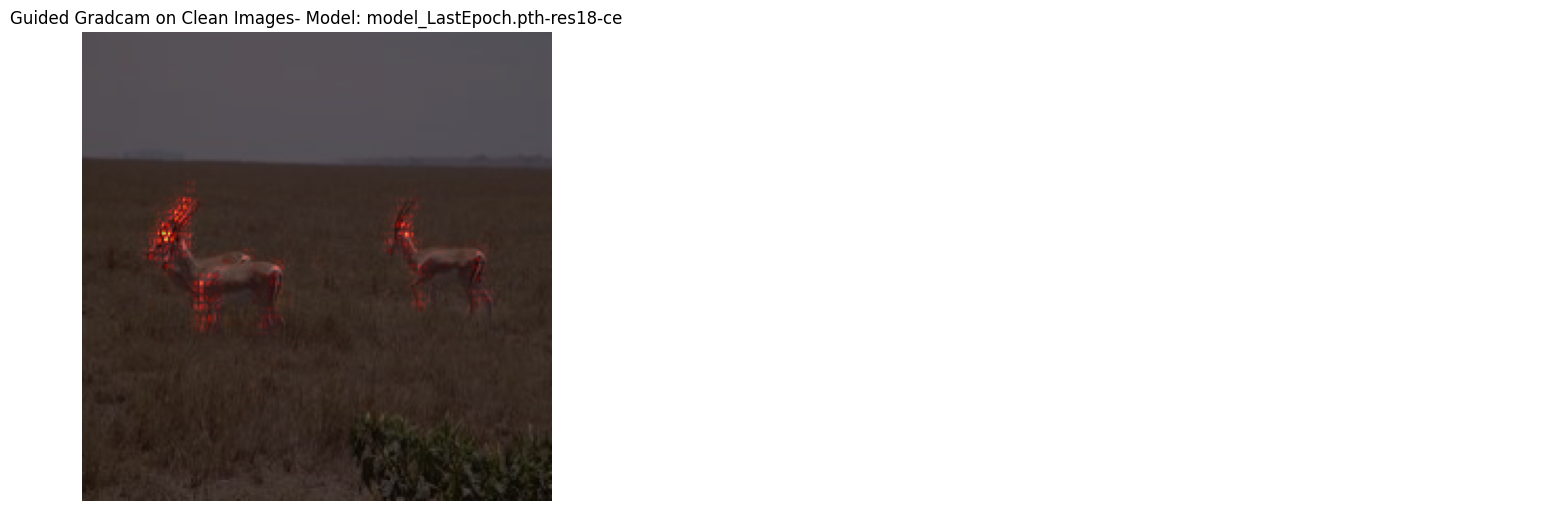

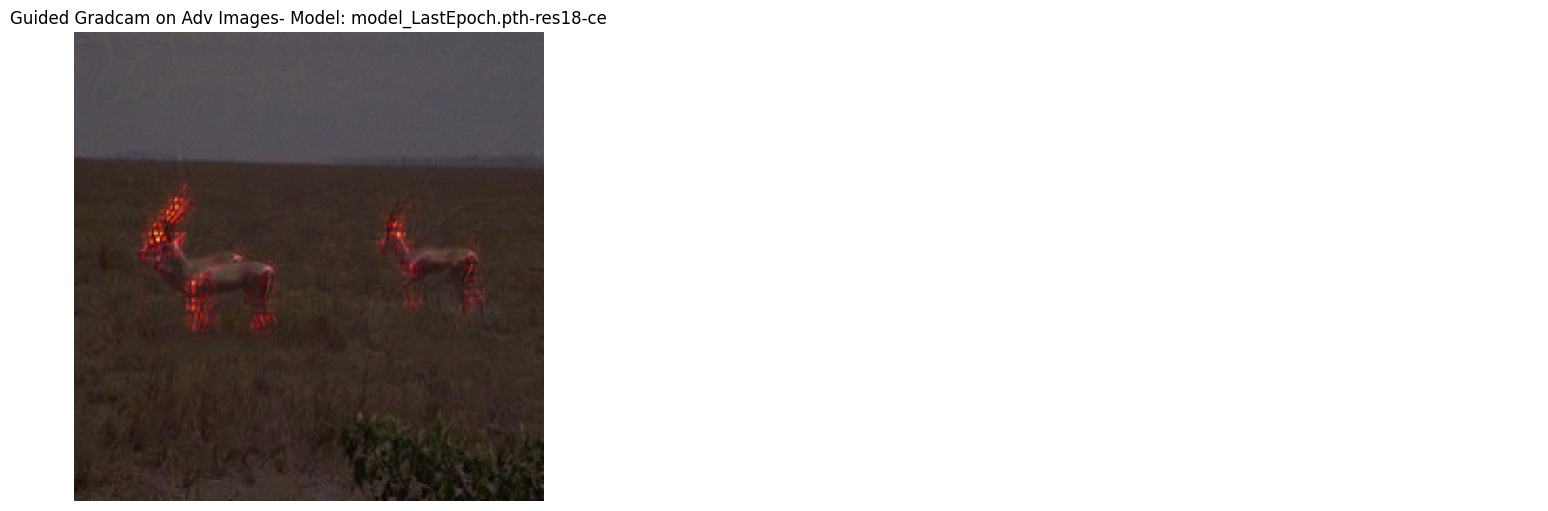

In [15]:
#Guided Gradcam On Clean and Adversarial

model_res18.load_state_dict(torch.load(model_path))
model_res18 = model_res18.to(device)
model_res18.eval()
info = p.split('/')
    
with torch.no_grad():
    outputs = model_res18(all_adv_images[2:3])
    _, adv_predicted = torch.max(outputs, 1)
        
with torch.no_grad():
    outputs = model_res18(all_org_images[2:3])
    _, org_predicted = torch.max(outputs, 1)
    
attributions_org_ggcam = compute_guided_gradcam_attributions(all_org_images[2:3], org_predicted, model_res18,model_res18.layer4)
visualize_all_attributions(all_org_images[2], [attributions_org_ggcam], [f'Guided Gradcam on Clean Images- Model: {info[-1]}-{info[-2]}'])
    
attributions_adv_ggcam = compute_guided_gradcam_attributions(all_adv_images[2:3], adv_predicted, model_res18,model_res18.layer4)
visualize_all_attributions(all_adv_images[2], [attributions_adv_ggcam], [f'Guided Gradcam on Adv Images- Model: {info[-1]}-{info[-2]}'])